# Flower Classification with VGG16
### Author: Salma OUARDI
Dataset: [Flowers Recognition](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition)

### On import la base de données depuis Kaggle

In [72]:
# reset data dir
import os,sys

PROJ_DIR='/home/logic/_wsl_workspace/google-colab-playlist/kaggle/ML_vinniesniper-54816'
STORE_DIR=os.path.join(PROJ_DIR, '00_store')
DATA_DIR=os.path.join(PROJ_DIR, '01_data')
TMP_DIR=os.path.join(PROJ_DIR, '02_tmp')

MODEL_DIR=os.path.join(PROJ_DIR, '03_model')

# !rm -rf {PROJ_DIR}/data/*

# environment 

# originally 240,240
# size=(150,150)
image_w = 150
image_h = 150


In [ ]:
# !rm /root/.keras/datasets/flower_photos/LICENSE.txt
# # !ls -l /root/.keras/datasets/flower_photos

# !rm -rf /kaggle/working/dataset
# !cp -r /root/.keras/datasets/flower_photos/ /kaggle/working/dataset
# !ls -l /kaggle/working/dataset

# DATASET_DIR = '/kaggle/working/dataset'

In [51]:
%pip install kaggle
%pip install pandas
%pip install seaborn
%pip install scipy
%pip install pickle

import os
import shutil
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import matplotlib.image as mimg

import tensorflow as tf
print(tf.__version__)
# tensorflow 2.16 allows 
# from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array

from keras.utils import load_img, img_to_array
from keras import optimizers

from keras import layers
from keras import models
from keras import optimizers

import pickle
import json


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip in

In [52]:
# Check for the directory and if it doesn't exist, make one.
cache_dir = expanduser(join('~', '.keras'))
if not exists(cache_dir):
    makedirs(cache_dir)
    
# make the models sub-directory
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)

In [54]:
# Each species of flower is contained in a separate folder. Get all the sub directories
flower_types = os.listdir(STORE_DIR)
print("Types of flowers found: ", len(flower_types))
print("Categories of flowers: ", flower_types)

Types of flowers found:  5
Categories of flowers:  ['horse', 'beach', 'bus', 'building', 'flower']


In [ ]:
import os

num_skipped = 0
for folder_name in flower_types:
    folder_path = os.path.join(DATA_DIR, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

In [55]:
# A list that is going to contain tuples: (species of the flower, corresponding image path)
flowers = []

for species in flower_types:
    # Get all the file names
    all_flowers = os.listdir(STORE_DIR +"/"+ species)
    # Add them to the list
    for flower in all_flowers:
        flowers.append((species, str(STORE_DIR +"/"+species) + '/' + flower))

# Build a dataframe        
flowers = pd.DataFrame(data=flowers, columns=['category', 'image'], index=None)
flowers.head()

,category,image
0,horse,/home/logic/_wsl_workspace/google-colab-playli...
1,horse,/home/logic/_wsl_workspace/google-colab-playli...
2,horse,/home/logic/_wsl_workspace/google-colab-playli...
3,horse,/home/logic/_wsl_workspace/google-colab-playli...
4,horse,/home/logic/_wsl_workspace/google-colab-playli...


In [56]:
# Let's check how many samples for each category are present
print("Total number of flowers in the dataset: ", len(flowers))
fl_count = flowers['category'].value_counts()
print("Flowers in each category: ")
print(fl_count)

Total number of flowers in the dataset:  2500
Flowers in each category: 
category
horse       500
beach       500
bus         500
building    500
flower      500
Name: count, dtype: int64


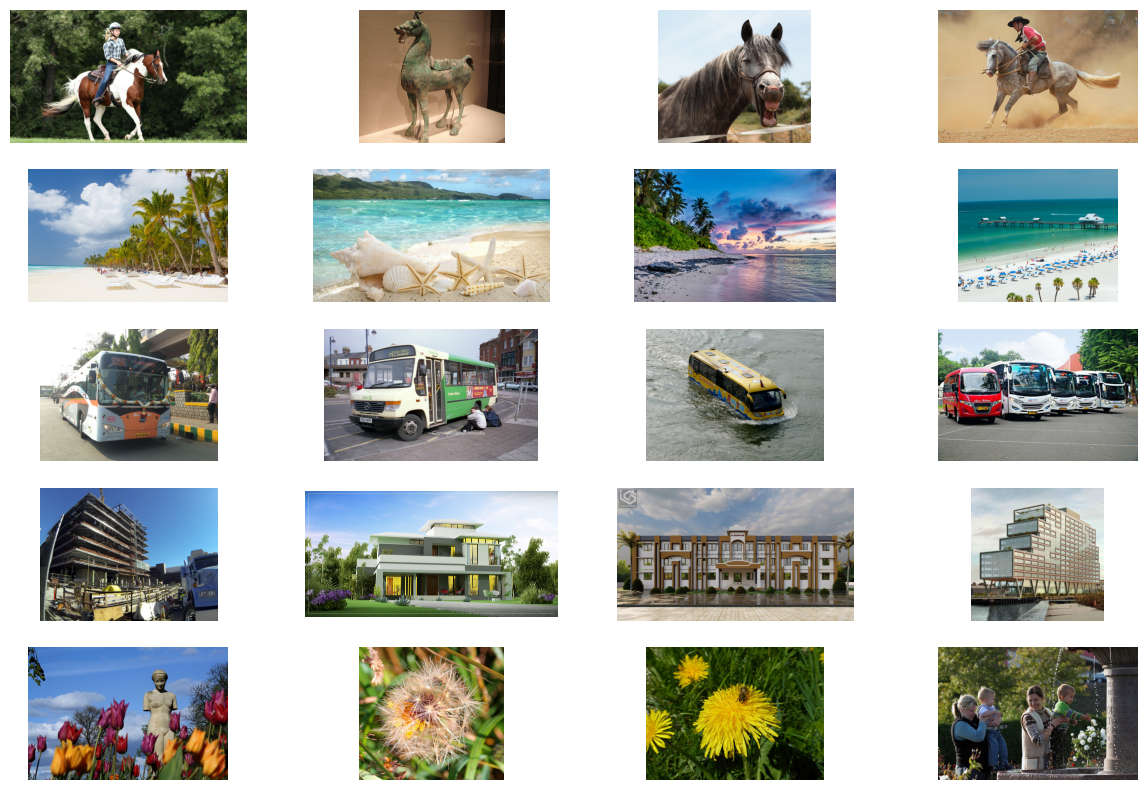

In [57]:
# Let's visualize some flowers from each category

# A list for storing names of some random samples from each category
random_samples = []

# Get samples fom each category 
for category in fl_count.index:
    samples = flowers['image'][flowers['category'] == category].sample(4).values
    for sample in samples:
        random_samples.append(sample)

# Plot the samples
f, ax = plt.subplots(5,4, figsize=(15,10))
for i,sample in enumerate(random_samples):
    ax[i//4, i%4].imshow(mimg.imread(random_samples[i]))
    ax[i//4, i%4].axis('off')
plt.show()    

### On va créer deux dossier 'Train' et 'Valid' pour notre modéle

In [58]:
# Make a parent directory `data` and two sub directories `train` and `valid`

%mkdir -p {DATA_DIR}/train
%mkdir -p {DATA_DIR}/valid

DATA_TRAIN_DIR=DATA_DIR+"/train"
DATA_VALID_DIR=DATA_DIR+"/valid"

for type in flower_types:
    %mkdir -p {DATA_TRAIN_DIR}/{type}
    %mkdir -p {DATA_VALID_DIR}/{type}

### On import nos catégories dans les deux dossiers 

In [59]:
for category in fl_count.index:
    samples = flowers['image'][flowers['category'] == category].values
    #perm = np.random.permutation(samples)
    # Copy first 100 samples to the validation directory and rest to the train directory

    print(samples[1])
    
    for i in range(100):
        name = samples[i].split('/')[-1]
        shutil.copyfile(samples[i],DATA_VALID_DIR+'/' + str(category) + '/'+ name)

    for i in range(100,len(samples)):
        name = samples[i].split('/')[-1]
        shutil.copyfile(samples[i],DATA_TRAIN_DIR+'/' + str(category) + '/' + name)

/home/logic/_wsl_workspace/google-colab-playlist/kaggle/ML_vinniesniper-54816/00_store/horse/horse_in_argentina_000135.jpg
/home/logic/_wsl_workspace/google-colab-playlist/kaggle/ML_vinniesniper-54816/00_store/beach/beach_000195.jpg
/home/logic/_wsl_workspace/google-colab-playlist/kaggle/ML_vinniesniper-54816/00_store/bus/bus_000198.jpg
/home/logic/_wsl_workspace/google-colab-playlist/kaggle/ML_vinniesniper-54816/00_store/building/building_000132.jpg
/home/logic/_wsl_workspace/google-colab-playlist/kaggle/ML_vinniesniper-54816/00_store/flower/1008566138_6927679c8a.jpg


### Comme modéle, on utilise VGG16 qui est un modéle Pretrained

In [60]:
from tensorflow.keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(image_w, image_h, 3))

2024-11-21 21:29:41.393737: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-21 21:29:41.397299: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (NVIDIA T400 4GB)
2024-11-21 21:29:42.204963: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 1 (Intel(R) Iris(R) Xe Graphics)
2024-11-21 21:29:42.289454: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-21 21:29:42.289479: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Yo

In [61]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [62]:
base_dir = DATA_DIR
train_dir = DATA_TRAIN_DIR
validation_dir = DATA_VALID_DIR

## Feature Extraction

In [63]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(5, activation='softmax'))

In [64]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 5)                 6

In [86]:
batch_size = 32

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        DATA_TRAIN_DIR,
        target_size=(image_w, image_h),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical'  # more than two classes
)

validation_generator = test_datagen.flow_from_directory(
        DATA_VALID_DIR,
        target_size=(image_w, image_h),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle = False
)

Found 2000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [87]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.0001),
              metrics=['acc'])

In [88]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.0001),
    metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 5)                 6

In [ ]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(
    monitor='val_acc', 
    mode='max', patience=5,  
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    # steps_per_epoch=100,
    epochs=50,# originally 6 epochs
    validation_data=validation_generator,
    # validation_steps=50
    callbacks=[es]
    )

Epoch 1/50


2024-11-21 21:56:11.180133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-21 21:56:11.277348: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-21 21:56:11.277381: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-21 21:56:11.277409: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 17714 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-11-21 21:56:11.277425: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

22/63 [=========>....................] - ETA: 29s - loss: 0.6055 - acc: 0.3267

In [73]:
model.save(MODEL_DIR+'/model.h5')

with open(MODEL_DIR+'/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history, file_pi)

with open(MODEL_DIR+'/model_architecture.json', 'w') as f:
    f.write(model.to_json())


INFO:tensorflow:Assets written to: ram://799887e1-91a3-4c62-bf76-52f19602c0fd/assets


INFO:tensorflow:Assets written to: ram://799887e1-91a3-4c62-bf76-52f19602c0fd/assets


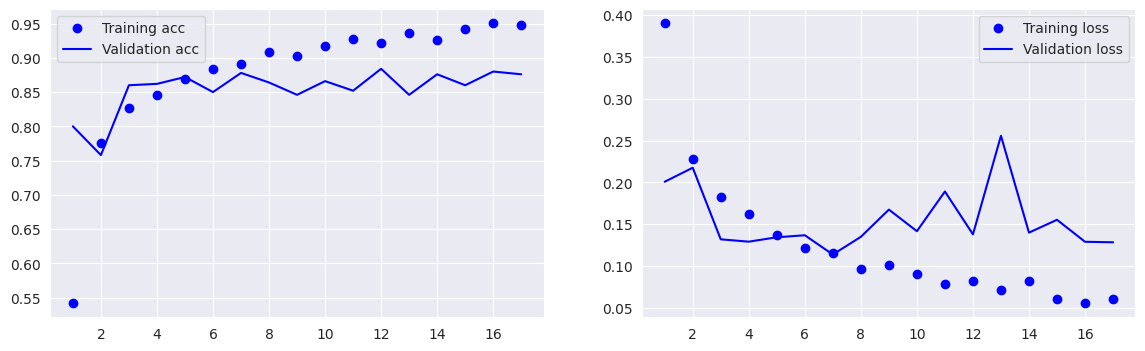

In [74]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

f, axes = plt.subplots(1,2,figsize=(14,4))

axes[0].plot(epochs, acc, 'bo', label='Training acc')
axes[0].plot(epochs, val_acc, 'b', label='Validation acc')
axes[0].legend()

axes[1].plot(epochs, loss, 'bo', label='Training loss')
axes[1].plot(epochs, val_loss, 'b', label='Validation loss')
axes[1].yaxis.set_label_position("right")
axes[1].legend()

plt.show()

In [75]:
model_3_val = val_acc[-1]
print("Validation Accuracy: ", model_3_val)

Validation Accuracy:  0.8760000467300415


In [76]:
def plot_confusion_matrix(cm, classes,                          normalize=False,                          title='Confusion matrix',                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(5,5))
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

/tmp/ipykernel_65798/189939870.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(validation_generator)
2024-11-21 21:53:43.095672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-21 21:53:50.398707: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-21 21:53:50.398770: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-21 21:53:50.398822: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow devi

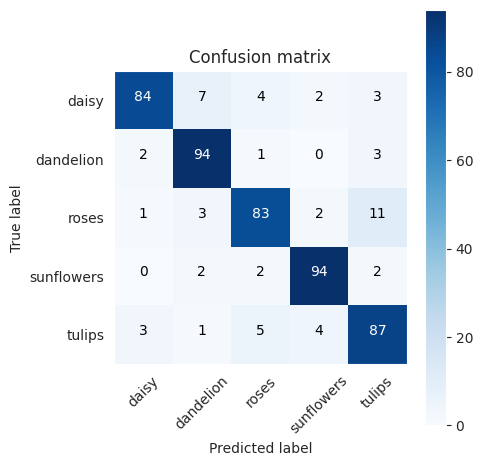

In [77]:
validation_generator.reset()
y_pred = model.predict_generator(validation_generator)
y_pred = y_pred.argmax(-1)
con_mat = tf.math.confusion_matrix(validation_generator.classes, y_pred)
con_mat = np.array(con_mat)
plot_confusion_matrix(cm = con_mat, classes = validation_generator.class_indices.keys(), normalize = False)

2405963/2405963 [==============================] - 0s 0us/step


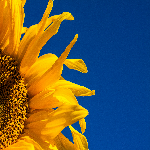

In [79]:
!rm -rf /home/logic/.keras/datasets/Red_sunflower
sunflower_url = "https://images.unsplash.com/photo-1540457943340-2e70b692e50e"
# sunflower_url = "https://images.unsplash.com/photo-1544954412-78da2cfa1a0c"
# sunflower_url = "https://images.unsplash.com/photo-1550927049-d07581451e3c"
# sunflower_url = "https://images.unsplash.com/photo-1462216589242-9e3e00a47a48"
# sunflower_url = "https://images.unsplash.com/photo-1533523611631-15e4ef69be08"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

# train
# sunflower_path = "/home/logic/_wsl_workspace/google-colab-playlist/kaggle/data/valid/daisy/144099102_bf63a41e4f_n.jpg"
# sunflower_path = "/home/logic/_wsl_workspace/google-colab-playlist/kaggle/data/valid/tulips/11746548_26b3256922_n.jpg"
# sunflower_path = "/home/logic/_wsl_workspace/google-colab-playlist/kaggle/data/valid/sunflowers/6953297_8576bf4ea3.jpg"
# sunflower_path = "/home/logic/_wsl_workspace/google-colab-playlist/kaggle/data/train/tulips/17189526216_fa24dd541a_n.jpg"

# validation
# sunflower_path = "/home/logic/_wsl_workspace/google-colab-playlist/kaggle/data/valid/daisy/144099102_bf63a41e4f_n.jpg"
# sunflower_path = "/home/logic/_wsl_workspace/google-colab-playlist/kaggle/data/valid/dandelion/10683189_bd6e371b97.jpg"
# sunflower_path = "/home/logic/_wsl_workspace/google-colab-playlist/kaggle/data/valid/roses/159079265_d77a9ac920_n.jpg"
# sunflower_path = "/home/logic/_wsl_workspace/google-colab-playlist/kaggle/data/valid/tulips/11746548_26b3256922_n.jpg"
# sunflower_path = "/home/logic/_wsl_workspace/google-colab-playlist/kaggle/data/valid/sunflowers/6953297_8576bf4ea3.jpg"

img = tf.keras.utils.load_img(    sunflower_path, target_size=(image_h, image_w))

img


In [89]:
class_names = list(validation_generator.class_indices.keys())

import pandas as pd

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
# score = tf.nn.softmax(predictions[0])

data = np.array([class_names,predictions[0]])
print(pd.DataFrame(data))


1/1 [==============================] - 0s 80ms/step
       0         1    2       3      4
0  beach  building  bus  flower  horse
1    0.0       0.0  0.0     1.0    0.0


2024-11-21 21:56:04.376985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


### 85% Accuracy using VGG16.